## Data Imputation

In [15]:
import os
import pandas as pd
import numpy as np

In [18]:
path = os.path.join('..', 'data', 'horse-colic.csv')
df = pd.read_csv(path, header=None, na_values='?')

In [19]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,2.0,1,530101,38.5,66.0,28.0,3.0,3.0,NaN,2.0,...,45.0,8.4,NaN,NaN,2.0,2,11300,0,0,2
1,1.0,1,534817,39.2,88.0,20.0,NaN,NaN,4.0,1.0,...,50.0,85.0,2.0,2.0,3.0,2,2208,0,0,2
2,2.0,1,530334,38.3,40.0,24.0,1.0,1.0,3.0,1.0,...,33.0,6.7,NaN,NaN,1.0,2,0,0,0,1
3,1.0,9,5290409,39.1,164.0,84.0,4.0,1.0,6.0,2.0,...,48.0,7.2,3.0,5.3,2.0,1,2208,0,0,1
4,2.0,1,530255,37.3,104.0,35.0,NaN,NaN,6.0,2.0,...,74.0,7.4,NaN,NaN,2.0,2,4300,0,0,2


In [31]:
for i in range(df.shape[1]):
    n_miss = df[[i]].isnull().sum()
    percent = np.round(n_miss /  df.shape[0] * 100, 2)
    print(f'> {i}, Missing: {n_miss} ({percent}%)')

> 0, Missing: 0    1
dtype: int64 (0    0.33
dtype: float64%)
> 1, Missing: 1    0
dtype: int64 (1    0.0
dtype: float64%)
> 2, Missing: 2    0
dtype: int64 (2    0.0
dtype: float64%)
> 3, Missing: 3    60
dtype: int64 (3    20.0
dtype: float64%)
> 4, Missing: 4    24
dtype: int64 (4    8.0
dtype: float64%)
> 5, Missing: 5    58
dtype: int64 (5    19.33
dtype: float64%)
> 6, Missing: 6    56
dtype: int64 (6    18.67
dtype: float64%)
> 7, Missing: 7    69
dtype: int64 (7    23.0
dtype: float64%)
> 8, Missing: 8    47
dtype: int64 (8    15.67
dtype: float64%)
> 9, Missing: 9    32
dtype: int64 (9    10.67
dtype: float64%)
> 10, Missing: 10    55
dtype: int64 (10    18.33
dtype: float64%)
> 11, Missing: 11    44
dtype: int64 (11    14.67
dtype: float64%)
> 12, Missing: 12    56
dtype: int64 (12    18.67
dtype: float64%)
> 13, Missing: 13    104
dtype: int64 (13    34.67
dtype: float64%)
> 14, Missing: 14    106
dtype: int64 (14    35.33
dtype: float64%)
> 15, Missing: 15    247
dtype: int

### 1. Statistical Imputation with SimpleImputer

#### SimpleImputer Data Transform

In [21]:
from sklearn.impute import SimpleImputer

In [23]:
# Split input input and output
data = df.values
ix = [i for i in range(data.shape[1]) if i != 23]

x, y = data[:, ix], data[:, 23]

# Summarize total missing
print(f"Missing: {sum(np.isnan(x).flatten())}")

Missing: 1605


In [24]:
# define imputer
imputer = SimpleImputer(strategy='mean')

# fit on the dataset
imputer.fit(x)

# transform the dataset
x_trans = imputer.transform(x)

# summarize total missing
print(f'Missing: {sum(np.isnan(x_trans).flatten())}')

Missing: 0


#### SimpleImputer and Model Evaluation

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

In [27]:
# load datset
df = pd.read_csv(path, header=None, na_values='?')

# split into input and output elements
data = df.values
ix = [i for i in range(data.shape[1]) if i != 23]

x, y = data[:, ix], data[:, 23]

# define model pipeline
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])

# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=4)

print(f'Mean Accuracy: {np.mean(scores):.3f} ({np.std(scores):.3f})')

Mean Accuracy: 0.862 (0.055)


#### Comparing Different Imputed Statistics

Mean Accuracy: 0.866 (0.058)
Mean Accuracy: 0.873 (0.063)
Mean Accuracy: 0.872 (0.063)
Mean Accuracy: 0.877 (0.052)


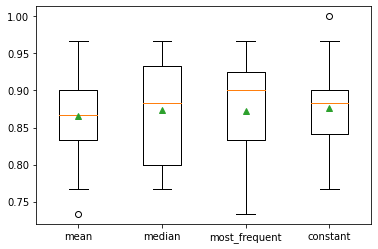

In [28]:
import matplotlib.pyplot as plt
# evaluate each strategy on the dataset
results = []
strategies = ['mean', 'median', 'most_frequent', 'constant']

for strategy in strategies:
    pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=strategy)), ('m', RandomForestClassifier())])
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=4)

    # store results
    results.append(scores)
    print(f'Mean Accuracy: {np.mean(scores):.3f} ({np.std(scores):.3f})')

# plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

#### SimpleImputer Transform WHen Making a prediction

In [30]:
# create the modeling pipeline
pipeline = Pipeline(steps=[('i', SimpleImputer(strategy='constant')), ('m', RandomForestClassifier())])

# fit the model
pipeline.fit(x, y)

# define new data
row = [2, 1, 530101, 38.50, 66, 28, 3, 3, np.nan, 2, 5, 4, 4, np.nan, np.nan, np.nan, 3, 5, 45.00, 8.40, np.nan, np.nan, 2, 11300, 00000, 00000, 2]

# make a prediction
yhat = pipeline.predict([row])
# summarize prediction
print(f'Predicted Class: {yhat[0]}')

Predicted Class: 2.0


### 2. KNN Imputation

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

#### KNNImputer Data Transform

In [5]:
path = os.path.join('..', 'data', 'horse-colic.csv')

# load datset
df = pd.read_csv(path, header=None, na_values='?')

# split into input and output elements
data = df.values
ix = [i for i in range(data.shape[1]) if i != 23]

x, y = data[:, ix], data[:, 23]

# summarize total missing
print(f'Missing: {sum(np.isnan(x).flatten())}')

# define imputer
imputer = KNNImputer()

# fit on the dataset
imputer.fit(x)

# transform the data
x_trans = imputer.transform(x)

# summarize total missing
print(f'Missing: {sum(np.isnan(x_trans).flatten())}')

Missing: 1605
Missing: 0


#### KNNImputer and Model Evaluation

In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

In [7]:
path = os.path.join('..', 'data', 'horse-colic.csv')

# load dataset
df = pd.read_csv(path, header=None, na_values='?')

# split into input and output elements
data = df.values
ix = [i for i in range(data.shape[1]) if i != 23]

x, y = data[:, ix], data[:, 23]

In [9]:
# define the modeling pipeline
model = RandomForestClassifier()
imputer = KNNImputer()

pipeline = Pipeline(steps=[('i', imputer), ('m', model)])

# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaulate model
scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=4)
print(f"Mean Accuracy: {np.mean(scores):.3f} ({np.std(scores):.3f})")

Mean Accuracy: 0.860 (0.059)


KNNImputer and Different Number of Neighbors

Mean Accuracy: 0.861 (0.056)
Mean Accuracy: 0.859 (0.054)
Mean Accuracy: 0.859 (0.056)
Mean Accuracy: 0.866 (0.051)
Mean Accuracy: 0.861 (0.060)


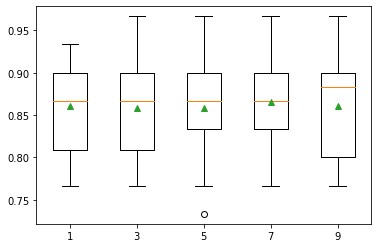

In [11]:
import matplotlib.pyplot as plt

results = []
strategies = [str(i) for i in [1,3,5,7,9]]

for s in strategies:
    # create the modeling pipelines
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])

    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=4)

    # store results
    results.append(scores)
    print(f"Mean Accuracy: {np.mean(scores):.3f} ({np.std(scores):.3f})")

plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

### How to Use Iterative Imputation